## Hyper-parameter

In [1]:
import sys
sys.path.append('..')
import utils
import mxnet as mx

num_epochs = 100
learning_rate = 0.1
weight_decay = 5e-4
lr_period = 30
lr_decay = 0.1
batch_size = 30
epoch_period = 10
ctx = utils.try_gpu()

## Define Model

In [2]:
from mxnet import gluon
from mxnet import init
drop_prob1 = 0.1
drop_prob2 = 0.1
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(64, activation="relu"))
    net.add(gluon.nn.Dropout(drop_prob1))
    net.add(gluon.nn.Dense(32, activation="relu"))
    net.add(gluon.nn.Dropout(drop_prob2))
    net.add(gluon.nn.Dense(10))
net.initialize(ctx=ctx, init=init.Xavier())

## Loading data and define Loss and Trainer

In [3]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import image
import utils
import numpy as np


fmnist_root="~/.mxnet/datasets/fashion-mnist"
mnist_root = "~/.mxnet/datasets/mnist"

def easy_transform(data, label):
    return data.astype('float32')/255, label.astype('float32')

def transform_train(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                        rand_crop=False, rand_resize=False, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]), 
                        std=np.array([0.2023, 0.1994, 0.2010]), 
                        brightness=0, contrast=0, 
                        saturation=0, hue=0, 
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), 
                        mean=np.array([0.4914, 0.4822, 0.4465]), 
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def dataset_split(data, ratio):
    split_point = int(len(data) * ratio)
    data=data[:]
    X = data[0]
    y = nd.array(data[1])
    n = X.shape[0]
    idx = np.arange(n)
    np.random.shuffle(idx)
    X = nd.array(X.asnumpy()[idx])
    y = nd.array(y.asnumpy()[idx])
    X_train = X[:split_point]
    y_train = y[:split_point]
    X_valid = X[split_point:]
    y_valid = y[split_point:]
    train_dataset= gluon.data.ArrayDataset(X_train, y_train)
    test_dataset = gluon.data.ArrayDataset(X_valid, y_valid)
    return train_dataset, test_dataset

def evaluate_loss(loss_func, data_iterator, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    total_loss = 0.0
    if isinstance(data_iterator, mx.io.MXDataIter):
        data_iterator.reset()
    for data, label in data_iterator:
        cur_loss = softmax_cross_entropy(net(data), label).copyto(mx.cpu())
        total_loss += nd.mean(cur_loss).asscalar()
    return total_loss

validation_ratio = 0.3

mnist_train_valid = gluon.data.vision.MNIST(train=True, transform=easy_transform)
mnist_test = gluon.data.vision.MNIST(train=False, transform=easy_transform)
mnist_train, mnist_valid = dataset_split(mnist_train_valid, validation_ratio)

# cifar_train_valid = gluon.data.vision.CIFAR10(train=True, transform=easy_transform)
# cifar_test = gluon.data.vision.CIFAR10(train=False, transform=easy_transform)
# cifar_train, cifar_valid = dataset_split(cifar_train_valid, validation_ratio)

In [4]:
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(mnist_valid, batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(mnist_train_valid, batch_size, shuffle=True, last_batch='keep')

# 
# train_data = gluon.data.DataLoader(cifar_train, batch_size, shuffle=True, last_batch='keep')
# valid_data = gluon.data.DataLoader(cifar_valid, batch_size, shuffle=True, last_batch='keep')
# train_valid_data = gluon.data.DataLoader(mnist_train_valid, batch_size, shuffle=True, last_batch='keep')
# 

test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=False, last_batch='keep')
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## Training and testing

In [19]:
import datetime

def train(net, train_data, valid_data, epochs, lr, wd, lr_period, lr_decay, epoch_period, ctx):
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    net.collect_params().initialize(force_reinit=True)
    cur_train_loss = [evaluate_loss(softmax_cross_entropy,train_data, net, ctx) / len(train_data)]
    if valid_data is not None:
        cur_valid_loss = [evaluate_loss(softmax_cross_entropy,valid_data, net, ctx) / len(valid_data)]
    print("start")
    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data.as_in_context(ctx))
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
            train_acc += utils.accuracy(output, label)
        
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        cur_train_loss.append(train_loss / len(train_data))
        
        if valid_data != None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)   
            cur_valid_loss.append(evaluate_loss(softmax_cross_entropy,valid_data, net, ctx) / len(valid_data))
            epoch_str = ("Epoch %d. Loss: %f, Train acc %f, Valid acc %f, "
                            % (epoch, train_loss / len(train_data),
                            train_acc / len(train_data), valid_acc))
        else:
            epoch_str = ("Epoch %d. Loss: %f, Train acc %f "
                            % (epoch, train_loss / len(train_data), train_acc / len(train_data)))
        
        prev_time = cur_time
        if epoch % epoch_period == 0 or epoch == epochs - 1 or epoch == 1:
            print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))
                         
    if valid_data != None:
        return cur_train_loss, cur_valid_loss
    else:
        return cur_train_loss

In [12]:
train_loss, valid_loss = train(net, train_data, valid_data, num_epochs, learning_rate, weight_decay, lr_period, lr_decay, epoch_period, ctx)

start
Epoch 1. Loss: 0.746879, Train acc 0.769667, Valid acc 0.900762, Time 00:00:04, lr 0.1
Epoch 10. Loss: 0.367096, Train acc 0.900278, Valid acc 0.925071, Time 00:00:04, lr 0.1
Epoch 20. Loss: 0.365886, Train acc 0.902444, Valid acc 0.923119, Time 00:00:04, lr 0.1
Epoch 30. Loss: 0.220623, Train acc 0.941333, Valid acc 0.949167, Time 00:00:04, lr 0.010000000000000002
Epoch 40. Loss: 0.107217, Train acc 0.969222, Valid acc 0.957762, Time 00:00:05, lr 0.010000000000000002
Epoch 50. Loss: 0.089153, Train acc 0.975833, Valid acc 0.958143, Time 00:00:04, lr 0.010000000000000002
Epoch 60. Loss: 0.069405, Train acc 0.980000, Valid acc 0.961214, Time 00:00:03, lr 0.0010000000000000002
Epoch 70. Loss: 0.063618, Train acc 0.982611, Valid acc 0.961500, Time 00:00:04, lr 0.0010000000000000002
Epoch 80. Loss: 0.061618, Train acc 0.983167, Valid acc 0.961857, Time 00:00:04, lr 0.0010000000000000002
Epoch 90. Loss: 0.059926, Train acc 0.984000, Valid acc 0.961595, Time 00:00:04, lr 0.000100000000

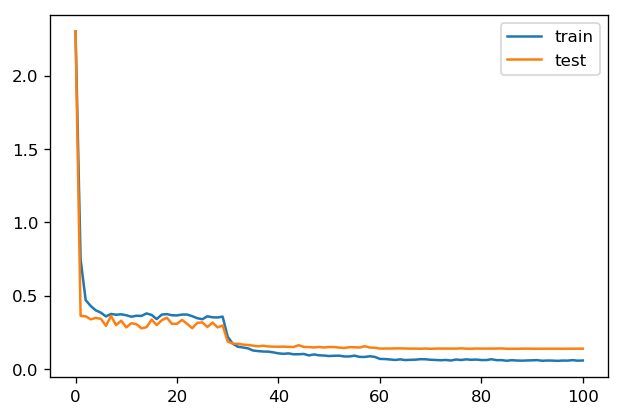

In [13]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','test'])

In [20]:
train_loss = train(net, train_valid_data, None, num_epochs, learning_rate, weight_decay, lr_period, lr_decay, epoch_period, ctx)

start
Epoch 1. Loss: 0.529785, Train acc 0.847450 Time 00:00:17, lr 0.1
Epoch 10. Loss: 0.397663, Train acc 0.896533 Time 00:00:10, lr 0.1
Epoch 20. Loss: 0.399428, Train acc 0.894283 Time 00:00:10, lr 0.1
Epoch 30. Loss: 0.258840, Train acc 0.931367 Time 00:00:09, lr 0.010000000000000002
Epoch 40. Loss: 0.157921, Train acc 0.954117 Time 00:00:09, lr 0.010000000000000002
Epoch 50. Loss: 0.139286, Train acc 0.959283 Time 00:00:10, lr 0.010000000000000002
Epoch 60. Loss: 0.107241, Train acc 0.968417 Time 00:00:09, lr 0.0010000000000000002
Epoch 70. Loss: 0.101243, Train acc 0.970750 Time 00:00:09, lr 0.0010000000000000002
Epoch 80. Loss: 0.095782, Train acc 0.971233 Time 00:00:09, lr 0.0010000000000000002
Epoch 90. Loss: 0.093222, Train acc 0.972467 Time 00:00:09, lr 0.00010000000000000003
Epoch 99. Loss: 0.091324, Train acc 0.973750 Time 00:00:09, lr 0.00010000000000000003
Epoch 100. Loss: 0.092046, Train acc 0.973083 Time 00:00:10, lr 0.00010000000000000003


In [25]:
test_acc = utils.evaluate_accuracy(test_data, net, ctx)
print( "the final test_acc %f" %(test_acc))

the final test_acc 0.972400
